# Importing necessary things

In [1]:
#conda install -c conda-forge fbprophet
#conda install -c conda-forge/label/cf201901 fbprophet
#pip install fbprophet
#pip install holidays==0.9.12
#pip install --upgrade plotly

#conda install nb_conda jupyter
#pip install pmdarima

In [82]:
import pickle
import bz2

import pandas as pd
import time
import warnings                                  
warnings.filterwarnings('ignore')

import numpy as np                                                            
import matplotlib.pyplot as plt                  
import seaborn as sns                            

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
import scipy.stats as scs

from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from fbprophet import Prophet

import xgboost as xgb
from xgboost import plot_importance, plot_tree

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pmdarima as pm
from pmdarima import auto_arima
from pmdarima.arima import ADFTest
from pmdarima.arima.utils import ndiffs

------------

# Looking at the dataframe

In [3]:
# Bring dataset from pickle

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = pickle.load(data)
    return data

In [4]:
df = decompress_pickle('data/compressedpz.pbz2')
df

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,timestamp_dev_responded,developer_response
84652123,84652123,"{'steamid': '76561198044182675', 'num_games_ow...",english,Don't get me wrong this game is amazing. I spe...,1610600299,1610600299,False,0,0,0,0,True,False,True,NaN,NaN
84650292,84650292,"{'steamid': '76561198189260829', 'num_games_ow...",english,ME LIKE!!,1610596706,1610596706,True,0,0,0,0,True,False,True,NaN,NaN
84647357,84647357,"{'steamid': '76561197968351158', 'num_games_ow...",english,Really good game. Make sure you opt into the b...,1610591400,1610591400,True,0,0,0,0,True,False,True,NaN,NaN
84646408,84646408,"{'steamid': '76561198025117668', 'num_games_ow...",english,Project Zomboid is THE zombie survival game. W...,1610589741,1610589741,True,0,0,0,0,True,False,True,NaN,NaN
84643897,84643897,"{'steamid': '76561198024526105', 'num_games_ow...",english,Less of an action-packed zombie apocalypse gam...,1610585302,1610585302,True,0,0,0,0,True,False,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7602280,7602280,"{'steamid': '76561198067098561', 'num_games_ow...",english,This is a must buy! It's a really unique game ...,1383932465,1383932465,True,0,0,0,0,False,False,True,NaN,NaN
7602237,7602237,"{'steamid': '76561198043807990', 'num_games_ow...",english,Fans of serious zombie survival games that is ...,1383932174,1385746707,True,20,0,0.715714693069458008,0,False,False,True,NaN,NaN
7602221,7602221,"{'steamid': '76561197981939207', 'num_games_ow...",brazilian,Esse jogo é muito bacana para quem gosta de um...,1383932039,1385658239,True,23,0,0.741350948810577393,0,False,False,True,NaN,NaN
7602166,7602166,"{'steamid': '76561198024263590', 'num_games_ow...",english,"2013:After a really, really long wait it's fin...",1383931617,1575136783,True,0,0,0,0,False,False,True,NaN,NaN


------

# Cleaning the data

In [5]:
# Checking for null values
# Almost all the reviews have no responses from the dev.

df.isna().sum()

recommendationid                   0
author                             0
language                           0
review                             0
timestamp_created                  0
timestamp_updated                  0
voted_up                           0
votes_up                           0
votes_funny                        0
weighted_vote_score                0
comment_count                      0
steam_purchase                     0
received_for_free                  0
written_during_early_access        0
timestamp_dev_responded        33976
developer_response             33976
dtype: int64

In [6]:
# Dropping columns that are not particularly useful.

df = df.drop(columns=['recommendationid', 'author', 'timestamp_updated', 'timestamp_dev_responded', 'developer_response', 'written_during_early_access'])
df.head()

,language,review,timestamp_created,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free
84652123,english,Don't get me wrong this game is amazing. I spe...,1610600299,False,0,0,0,0,True,False
84650292,english,ME LIKE!!,1610596706,True,0,0,0,0,True,False
84647357,english,Really good game. Make sure you opt into the b...,1610591400,True,0,0,0,0,True,False
84646408,english,Project Zomboid is THE zombie survival game. W...,1610589741,True,0,0,0,0,True,False
84643897,english,Less of an action-packed zombie apocalypse gam...,1610585302,True,0,0,0,0,True,False


In [7]:
# Changing epoch time to readable format. Removing timestamp for ease of time series.
df['timestamp_created'] = [time.strftime('%Y-%m-%d', time.localtime(x)) for x in df['timestamp_created']]
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], format='%Y-%m-%d')

# Changing name of column for ease. 
df = df.rename(columns={'timestamp_created':'reviewtimeposted'})
df

,language,review,reviewtimeposted,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free
84652123,english,Don't get me wrong this game is amazing. I spe...,2021-01-13,False,0,0,0,0,True,False
84650292,english,ME LIKE!!,2021-01-13,True,0,0,0,0,True,False
84647357,english,Really good game. Make sure you opt into the b...,2021-01-13,True,0,0,0,0,True,False
84646408,english,Project Zomboid is THE zombie survival game. W...,2021-01-13,True,0,0,0,0,True,False
84643897,english,Less of an action-packed zombie apocalypse gam...,2021-01-13,True,0,0,0,0,True,False
...,...,...,...,...,...,...,...,...,...,...
7602280,english,This is a must buy! It's a really unique game ...,2013-11-08,True,0,0,0,0,False,False
7602237,english,Fans of serious zombie survival games that is ...,2013-11-08,True,20,0,0.715714693069458008,0,False,False
7602221,brazilian,Esse jogo é muito bacana para quem gosta de um...,2013-11-08,True,23,0,0.741350948810577393,0,False,False
7602166,english,"2013:After a really, really long wait it's fin...",2013-11-08,True,0,0,0,0,False,False


-----

# Checking distribution of reviews

In [8]:
# About half the reviews are in English as indicated by the reviewers.

df['language'].value_counts()

english       16263
russian        6942
schinese       2300
spanish        1552
brazilian      1416
french         1236
koreana         877
turkish         745
german          722
polish          550
tchinese        223
japanese        202
italian         199
latam           132
czech           103
thai             99
portuguese       90
dutch            65
swedish          63
finnish          46
danish           42
hungarian        41
ukrainian        32
norwegian        27
bulgarian         7
greek             6
romanian          5
vietnamese        5
Name: language, dtype: int64

In [9]:
# A large majority of people reviewed the game positively.

df['voted_up'].value_counts()

True     30418
False     3572
Name: voted_up, dtype: int64

In [10]:
# A large majority of people who made reviews purchased the game on Steam.

df['steam_purchase'].value_counts()

True     25751
False     8239
Name: steam_purchase, dtype: int64

In [11]:
# A vast majority of people who made reviews paid for the game.

df['received_for_free'].value_counts()

False    33521
True       469
Name: received_for_free, dtype: int64

----

# Removing outliers

## Hampel Filter

In [18]:
# Turning dataframe into time series format.

reviewcount = df['reviewtimeposted'].value_counts().rename_axis('date').reset_index(name='dailycount')
reviewcount = reviewcount.sort_values(by='date')
reviewcount.set_index('date', inplace=True)
reviewcount.head()

,dailycount
date,
2013-11-08,58
2013-11-09,46
2013-11-10,37
2013-11-11,21
2013-11-12,22


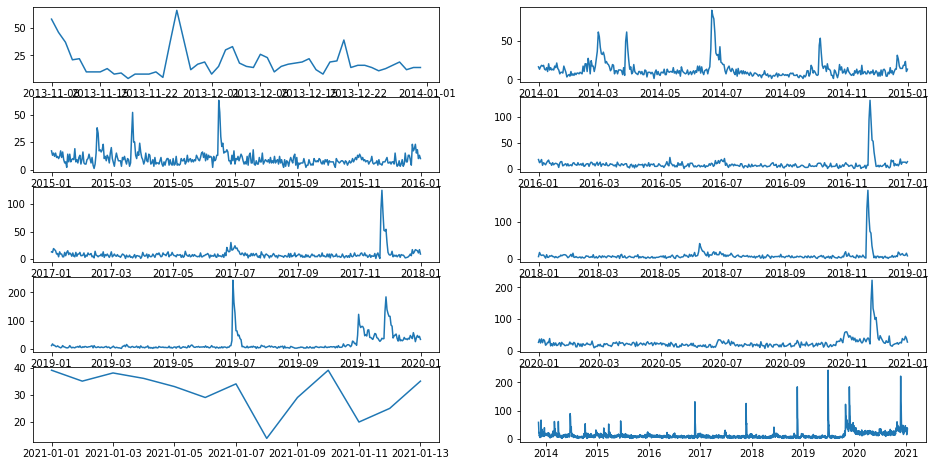

In [13]:
# Taking a look at number of reviews every year.

reviewcount13 = reviewcount['2013-01-01':'2013-12-31']
reviewcount14 = reviewcount['2014-01-01':'2014-12-31']
reviewcount15 = reviewcount['2015-01-01':'2015-12-31']
reviewcount16 = reviewcount['2016-01-01':'2016-12-31']
reviewcount17 = reviewcount['2017-01-01':'2017-12-31']
reviewcount18 = reviewcount['2018-01-01':'2018-12-31']
reviewcount19 = reviewcount['2019-01-01':'2019-12-31']
reviewcount20 = reviewcount['2020-01-01':'2020-12-31']
reviewcount21 = reviewcount['2021-01-01':'2021-12-31']

fig, axes = plt.subplots(5, 2, figsize=(16,8))

axes[0, 0].plot(reviewcount13)
axes[0, 1].plot(reviewcount14)
axes[1, 0].plot(reviewcount15)
axes[1, 1].plot(reviewcount16)
axes[2, 0].plot(reviewcount17)
axes[2, 1].plot(reviewcount18)
axes[3, 0].plot(reviewcount19)
axes[3, 1].plot(reviewcount20)
axes[4, 0].plot(reviewcount21)
axes[4, 1].plot(reviewcount)

plt.show()

In [14]:
def hampel(vals_orig, k=7, t0=3):
    
    # Don't overwrite original
    vals = vals_orig.copy()
    
    # Hampel Filter
    L = 1.4826
    rolling_median = vals.rolling(window=k, center=True).median()
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_MAD = vals.rolling(window=k, center=True).apply(MAD)
    threshold = t0 * L * rolling_MAD
    difference = np.abs(vals - rolling_median) 
    outlier_idx = difference > threshold
    vals[outlier_idx] = rolling_median[outlier_idx] 
    
    return(vals)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


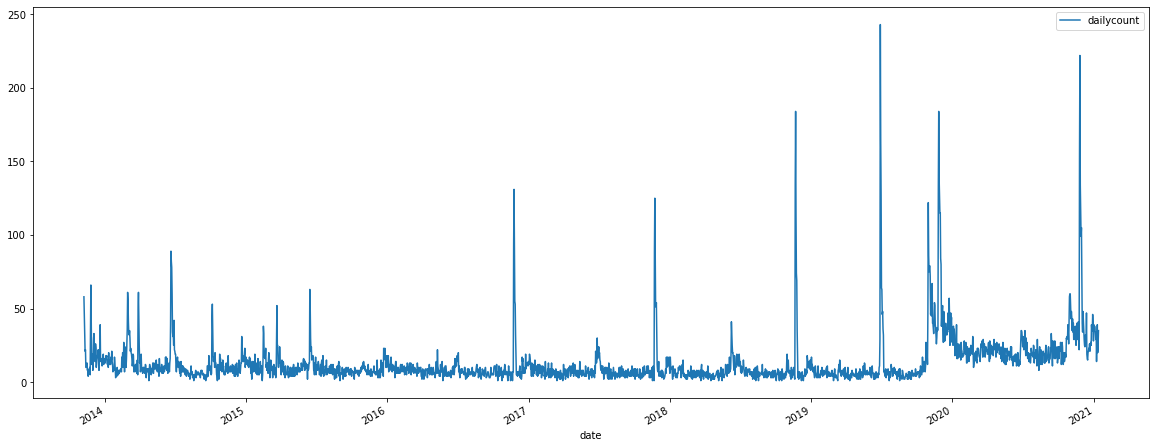

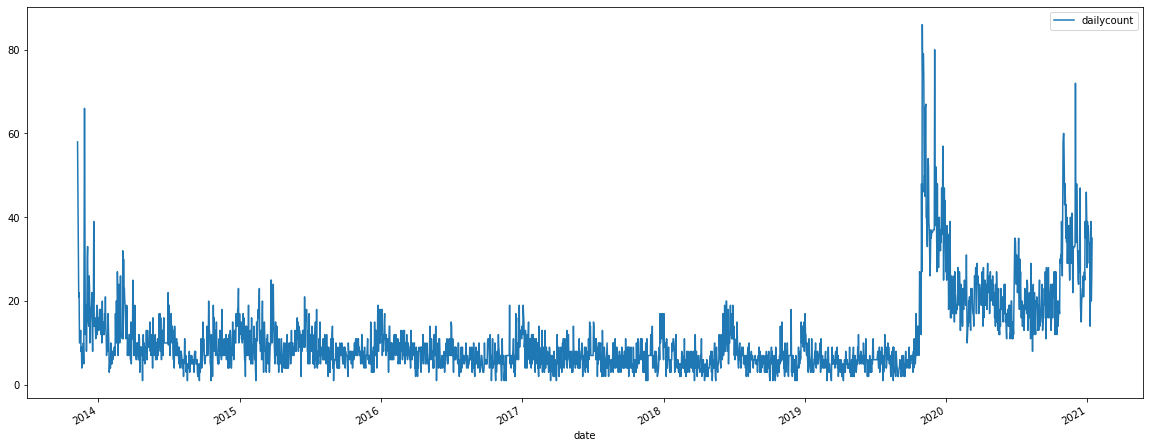

In [15]:
# k value chosen iteratively.

ts = reviewcount
hampts = hampel(ts, 90)

ts.plot(figsize = (20,8))
hampts.plot(figsize = (20,8))

plt.show()

In [23]:
# Adding a column with filtered values for later use.

reviewcount['dailycountfilter'] = pd.Series(hampts.values.flatten(), index=reviewcount.index)
reviewcount

,dailycount,dailycountfilter
date,,
2013-11-08,58,58.0
2013-11-09,46,46.0
2013-11-10,37,37.0
2013-11-11,21,21.0
2013-11-12,22,22.0
...,...,...
2021-01-09,29,29.0
2021-01-10,39,39.0
2021-01-11,20,20.0


In [24]:
# Checking how many values were changed from the original data.

reviewcount['filtered'] = np.where(reviewcount['dailycount'] == reviewcount['dailycountfilter'], True, False)
reviewcount['filtered'].value_counts()

True     2495
False     120
Name: filtered, dtype: int64

----

# Time Series Analysis

In [25]:
reviewcountmonthly = reviewcount['dailycountfilter'].resample('MS')
month_mean = reviewcountmonthly.mean()
month_mean

date
2013-11-01    20.695652
2013-12-01    17.419355
2014-01-01    12.806452
2014-02-01    12.321429
2014-03-01    14.387097
                ...    
2020-09-01    19.166667
2020-10-01    25.258065
2020-11-01    36.050000
2020-12-01    31.129032
2021-01-01    31.230769
Freq: MS, Name: dailycountfilter, Length: 87, dtype: float64

Text(0, 0.5, 'Number of Reviews')

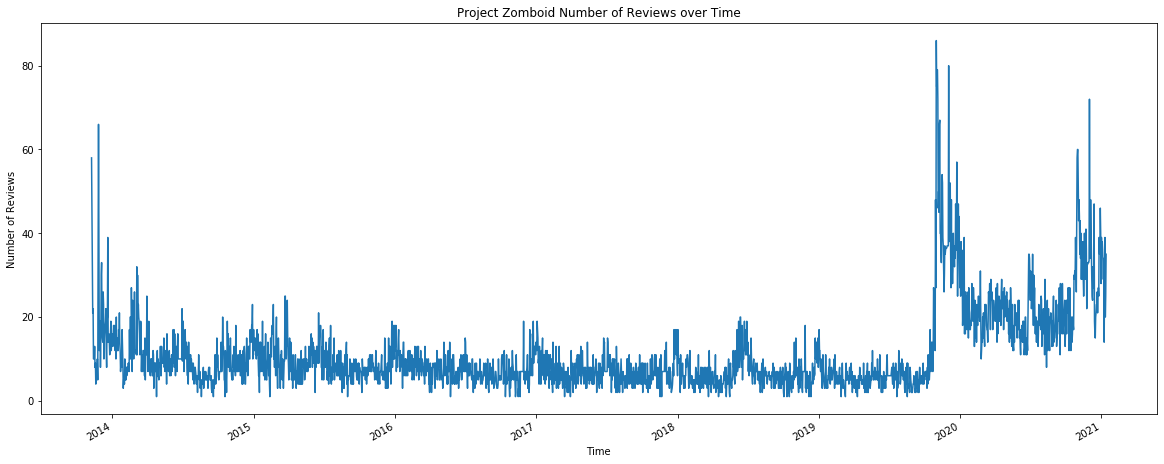

In [26]:
reviewcount['dailycountfilter'].plot(figsize = (20,8))
plt.title('Project Zomboid Number of Reviews over Time')
plt.xlabel('Time', fontsize=10)
plt.ylabel('Number of Reviews', fontsize=10)

Text(0, 0.5, 'Number of Reviews')

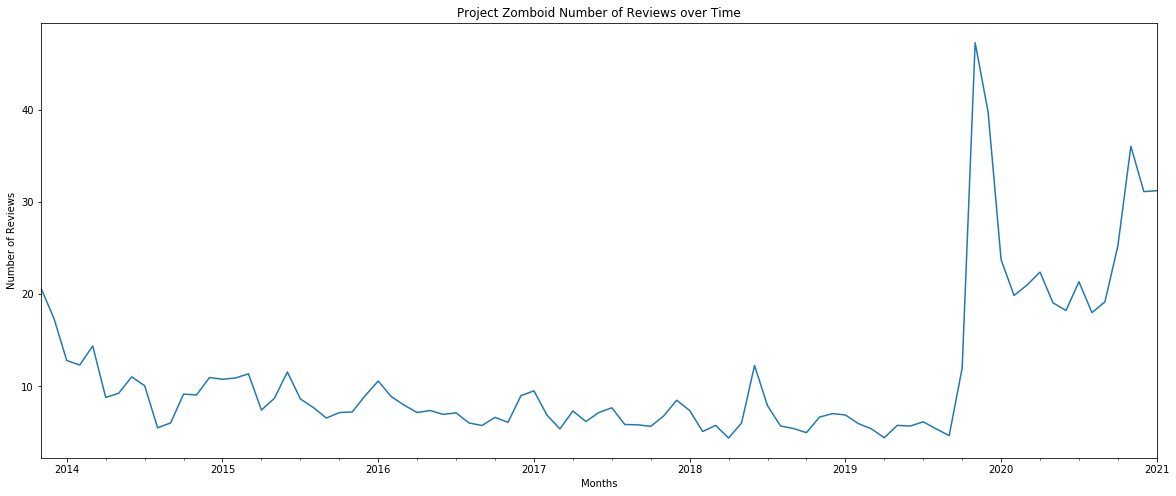

In [27]:
month_mean.plot(figsize = (20,8))
plt.title('Project Zomboid Number of Reviews over Time')
plt.xlabel('Months', fontsize=10)
plt.ylabel('Number of Reviews', fontsize=10)

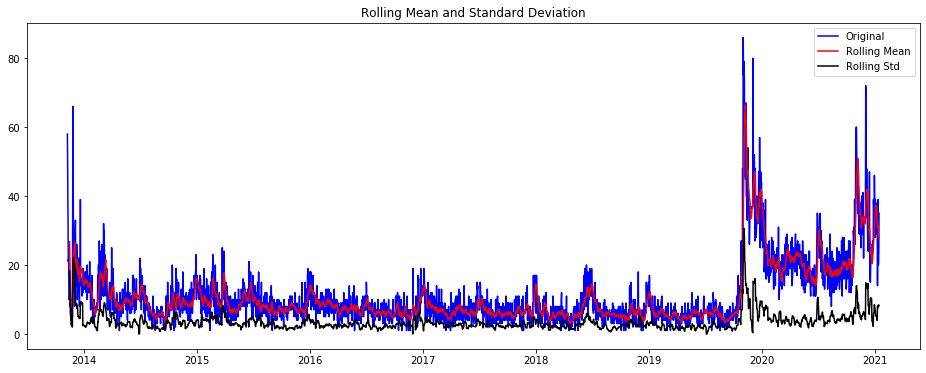

In [28]:
roll_mean = reviewcount['dailycountfilter'].rolling(window=8, center=False).mean()
roll_std = reviewcount['dailycountfilter'].rolling(window=8, center=False).std()

fig = plt.figure(figsize= (16,6))
plt.plot(reviewcount['dailycountfilter'], color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label='Rolling Std')
plt.title('Rolling Mean and Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

-----

# Stationarity Tests

### Summary Statistics

Text(0.5, 1.0, 'Distribution of Daily # of Reviews')

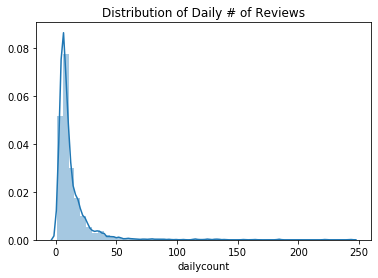

In [29]:
sns.distplot(reviewcount['dailycount'])
plt.title('Distribution of Daily # of Reviews')

In [30]:
X = reviewcount['dailycount'].values
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(),X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=10.279052, mean2=15.719204
variance1=90.387726, variance2=438.074941


Text(0.5, 1.0, 'Distribution of Daily # of Reviews')

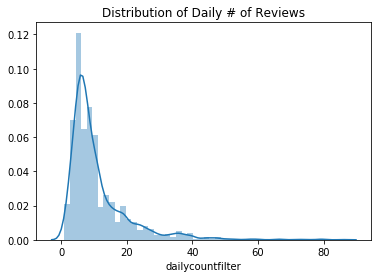

In [31]:
sns.distplot(reviewcount['dailycountfilter'])
plt.title('Distribution of Daily # of Reviews')

In [32]:
X = reviewcount['dailycountfilter'].values
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(),X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=8.976300, mean2=13.084162
variance1=27.172603, variance2=142.413728


### Dickey-Fuller Test

In [33]:
# This data is stationary within critical value 1%

dftest = adfuller(reviewcount['dailycount'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print('----------------------------------')
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

(-4.899112181992308, 3.50133966639758e-05, 27, 2587, {'1%': -3.4328802668982084, '5%': -2.862657875000973, '10%': -2.5673650853551155}, 18845.897585169278)
----------------------------------
Results of Dickey-Fuller test: 

Test Statistic                   -4.899112
p-value                           0.000035
#Lags Used                       27.000000
Number of Observations Used    2587.000000
Critical Value (1%)              -3.432880
Critical Value (5%)              -2.862658
Critical Value (10%)             -2.567365
dtype: float64


In [34]:
# This data is stationary within critical value 5%.

dftest = adfuller(reviewcount['dailycountfilter'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print('----------------------------------')
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

(-2.655577187551462, 0.08204580849300558, 28, 2586, {'1%': -3.4328812463201746, '5%': -2.8626583075270813, '10%': -2.5673653156355627}, 15079.719574627758)
----------------------------------
Results of Dickey-Fuller test: 

Test Statistic                   -2.655577
p-value                           0.082046
#Lags Used                       28.000000
Number of Observations Used    2586.000000
Critical Value (1%)              -3.432881
Critical Value (5%)              -2.862658
Critical Value (10%)             -2.567365
dtype: float64


### Looking at ACF and PACF

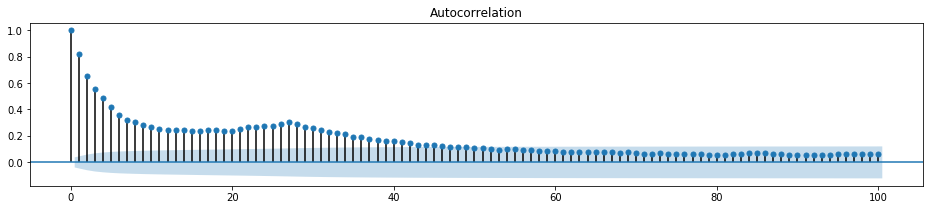

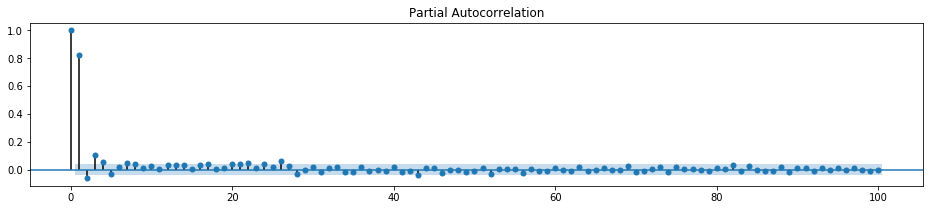

In [35]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(16,3))
plot_acf(reviewcount['dailycount'], ax=ax, lags=100);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(reviewcount['dailycount'], ax=ax, lags=100);

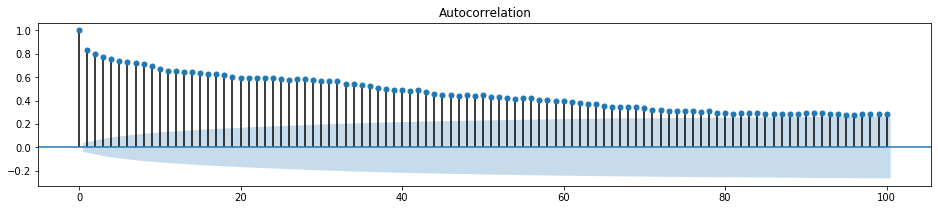

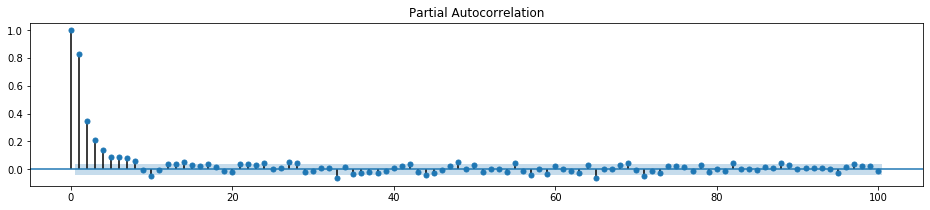

In [36]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(reviewcount['dailycountfilter'], ax=ax, lags=100);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(reviewcount['dailycountfilter'], ax=ax, lags=100);

------

# Forecast Modeling

In [37]:
# I chose this split date as the data is unusual due to a spike in reviews near the beginning of 2020.

split_date='2020-07-01'

train=reviewcount.loc[reviewcount.index <= split_date].copy()
test=reviewcount.loc[reviewcount.index > split_date].copy()

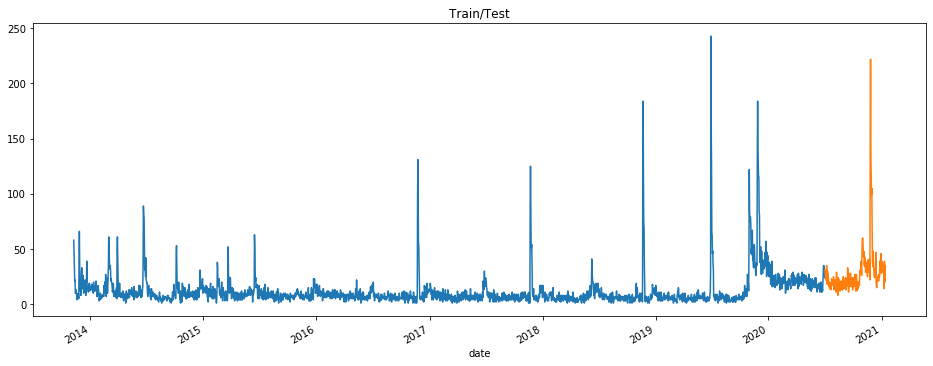

In [38]:
# Blue shows train data, orange shows test data.

train['dailycount'].plot(figsize=(16,6), title='Train/Test')
test['dailycount'].plot(figsize=(16,6), title='Train/Test')
plt.show()

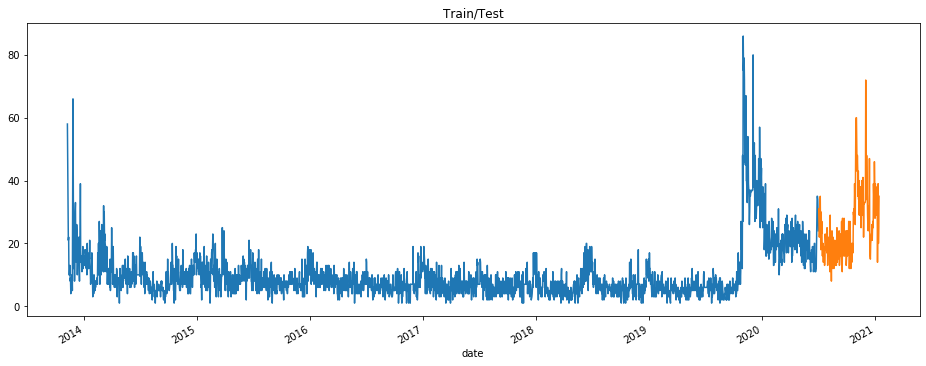

In [39]:
# Blue shows train data, orange shows test data.

train['dailycountfilter'].plot(figsize=(16,6), title='Train/Test')
test['dailycountfilter'].plot(figsize=(16,6), title='Train/Test')
plt.show()

----

## Naive Forecast

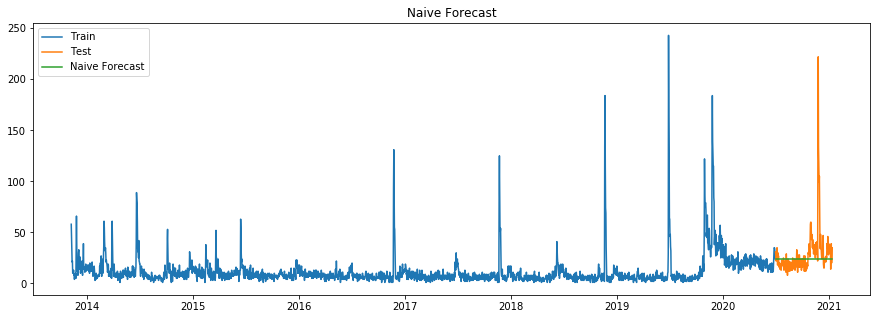

In [69]:
number = np.asarray(train['dailycount'])
y_hat = test.copy()
y_hat['naive'] = number[len(number)-1]

plt.figure(figsize=(15,5))
plt.plot(train.index, train['dailycount'], label='Train')
plt.plot(test.index,test['dailycount'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

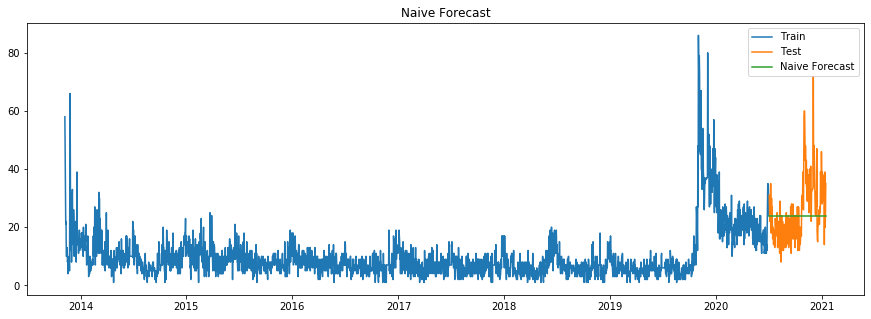

In [71]:
numberf = np.asarray(train['dailycountfilter'])
y_hatf = test.copy()
y_hatf['naive'] = number[len(number)-1]

plt.figure(figsize=(15,5))
plt.plot(train.index, train['dailycountfilter'], label='Train')
plt.plot(test.index,test['dailycountfilter'], label='Test')
plt.plot(y_hat.index,y_hatf['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [74]:
print(r2_score(y_true=test['dailycount'],
               y_pred=y_hat['naive']))

print(mean_squared_error(y_true=test['dailycount'],
                         y_pred=y_hat['naive']))

print(mean_absolute_error(y_true=test['dailycount'],
                         y_pred=y_hat['naive']))

print(mean_absolute_percentage_error(y_true=test['dailycount'],
                         y_pred=y_hat['naive']))

print('-------------------')

print(r2_score(y_true=test['dailycountfilter'],
               y_pred=y_hatf['naive']))

print(mean_squared_error(y_true=test['dailycountfilter'],
                         y_pred=y_hatf['naive']))

print(mean_absolute_error(y_true=test['dailycountfilter'],
                         y_pred=y_hatf['naive']))

print(mean_absolute_percentage_error(y_true=test['dailycountfilter'],
                         y_pred=y_hatf['naive']))

-0.04364652356950027
564.1122448979592
11.122448979591837
34.24892097861555
-------------------
-0.022196028116201916
109.69770408163265
7.85969387755102
32.581425187657466


## Prophet

In [44]:
tsprophet = train.drop(columns=['dailycountfilter', 'filtered'])
tsprophet = tsprophet.reset_index()
tsprophet = tsprophet.rename(columns={'date':'ds', 'dailycount':'y'})

tsprophettest = test.drop(columns=['dailycountfilter', 'filtered'])
tsprophettest = tsprophettest.reset_index()
tsprophettest = tsprophettest.rename(columns={'date':'ds', 'dailycount':'y'})

tsprophetf = train.drop(columns=['dailycount', 'filtered'])
tsprophetf = tsprophetf.reset_index()
tsprophetf = tsprophetf.rename(columns={'date':'ds', 'dailycountfilter':'y'})

tsprophettestf = test.drop(columns=['dailycount', 'filtered'])
tsprophettestf = tsprophettestf.reset_index()
tsprophettestf = tsprophettestf.rename(columns={'date':'ds', 'dailycountfilter':'y'})

In [45]:
model = Prophet() 
model.fit(tsprophet) 

testforecast = model.predict(df=tsprophettest)
testforecast.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-02,28.267254,20.758838,54.269229,28.267254,28.267254,9.017045,9.017045,9.017045,-0.796653,-0.796653,-0.796653,9.813697,9.813697,9.813697,0.0,0.0,0.0,37.284299
1,2020-07-03,28.303176,19.197002,53.249654,28.303176,28.303176,9.111015,9.111015,9.111015,-0.170404,-0.170404,-0.170404,9.281420,9.281420,9.281420,0.0,0.0,0.0,37.414192
2,2020-07-04,28.339098,20.924238,55.261945,28.339098,28.339098,10.054087,10.054087,10.054087,1.419037,1.419037,1.419037,8.635050,8.635050,8.635050,0.0,0.0,0.0,38.393186
3,2020-07-05,28.375020,20.000277,52.553080,28.375020,28.375020,9.013363,9.013363,9.013363,1.127449,1.127449,1.127449,7.885914,7.885914,7.885914,0.0,0.0,0.0,37.388383
4,2020-07-06,28.410942,19.358739,52.532042,28.410942,28.410942,6.795122,6.795122,6.795122,-0.252144,-0.252144,-0.252144,7.047266,7.047266,7.047266,0.0,0.0,0.0,35.206064


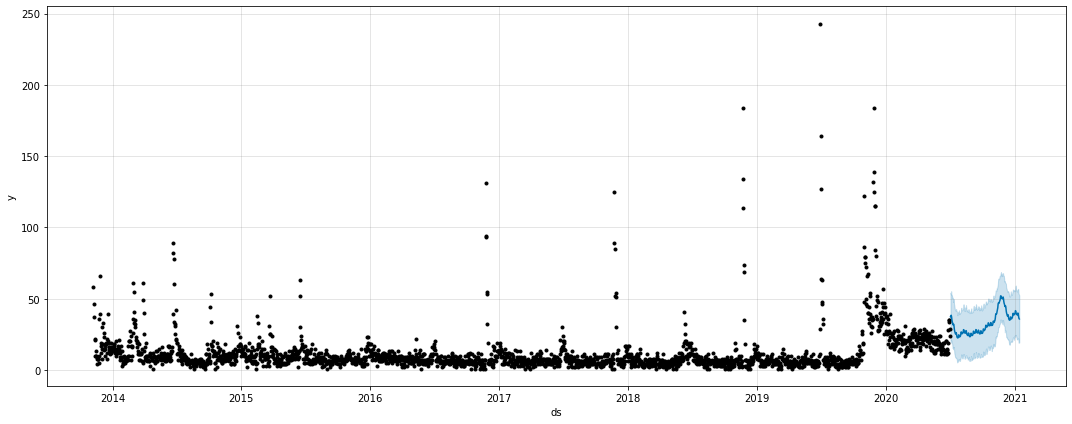

In [46]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)
fig = model.plot(testforecast, ax=ax)
plt.show()

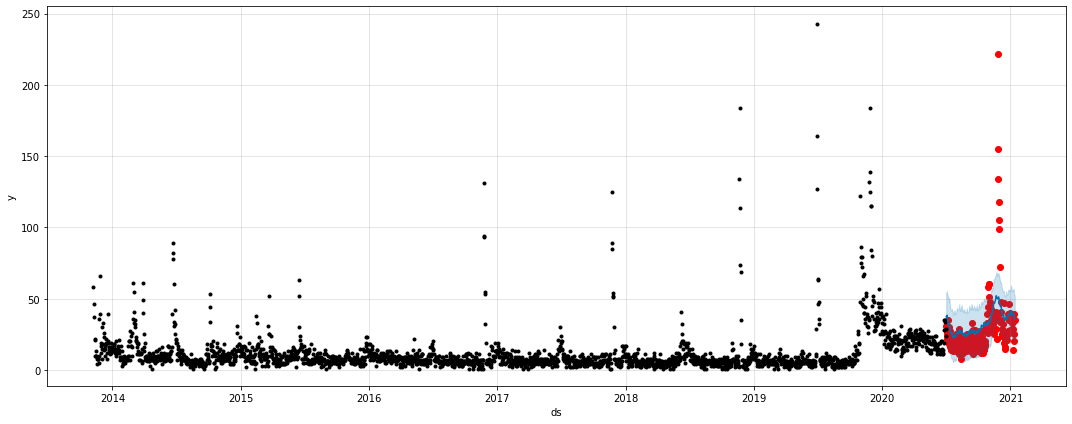

In [47]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)
ax.scatter(tsprophettest['ds'],tsprophettest['y'], color='r')
fig = model.plot(testforecast, ax=ax)
plt.show()

In [48]:
model2 = Prophet() 
model2.fit(tsprophetf) 

testforecastf = model.predict(df=tsprophettestf)
testforecastf.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-02,28.267254,20.391632,53.561586,28.267254,28.267254,9.017045,9.017045,9.017045,-0.796653,-0.796653,-0.796653,9.813697,9.813697,9.813697,0.0,0.0,0.0,37.284299
1,2020-07-03,28.303176,21.049538,53.795483,28.303176,28.303176,9.111015,9.111015,9.111015,-0.170404,-0.170404,-0.170404,9.281420,9.281420,9.281420,0.0,0.0,0.0,37.414192
2,2020-07-04,28.339098,22.092602,54.618498,28.339098,28.339098,10.054087,10.054087,10.054087,1.419037,1.419037,1.419037,8.635050,8.635050,8.635050,0.0,0.0,0.0,38.393186
3,2020-07-05,28.375020,21.978704,54.274608,28.375020,28.375020,9.013363,9.013363,9.013363,1.127449,1.127449,1.127449,7.885914,7.885914,7.885914,0.0,0.0,0.0,37.388383
4,2020-07-06,28.410942,18.512546,51.621462,28.410942,28.410942,6.795122,6.795122,6.795122,-0.252144,-0.252144,-0.252144,7.047266,7.047266,7.047266,0.0,0.0,0.0,35.206064


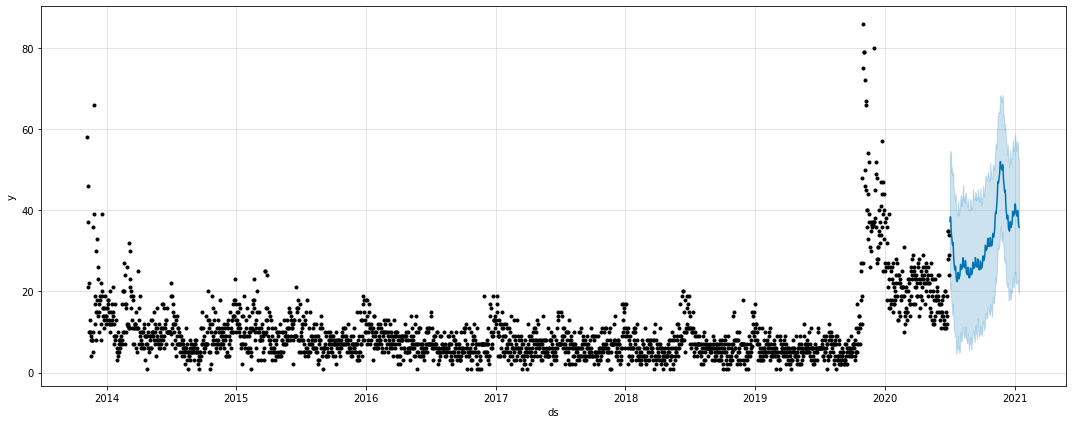

In [49]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)
fig = model2.plot(testforecastf, ax=ax)
plt.show()

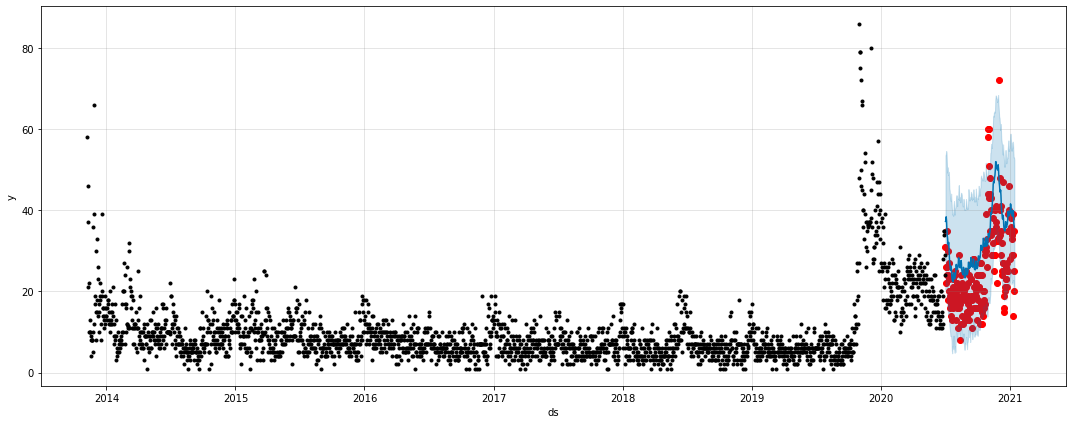

In [50]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)
ax.scatter(tsprophettestf['ds'],tsprophettestf['y'], color='r')
fig = model2.plot(testforecastf, ax=ax)
plt.show()

In [51]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

###########################################################

print(r2_score(y_true=tsprophettest['y'],
               y_pred=testforecast['yhat']))

print(mean_squared_error(y_true=tsprophettest['y'],
                         y_pred=testforecast['yhat']))

print(mean_absolute_error(y_true=tsprophettest['y'],
                         y_pred=testforecast['yhat']))

print(mean_absolute_percentage_error(y_true=tsprophettest['y'],
                         y_pred=testforecast['yhat']))

print('-------------------')

print(r2_score(y_true=tsprophettestf['y'],
               y_pred=testforecastf['yhat']))

print(mean_squared_error(y_true=tsprophettestf['y'],
                         y_pred=testforecastf['yhat']))

print(mean_absolute_error(y_true=tsprophettestf['y'],
                         y_pred=testforecastf['yhat']))

print(mean_absolute_percentage_error(y_true=tsprophettestf['y'],
                         y_pred=testforecastf['yhat']))

0.24708421512042555
406.96634735567284
11.534701969750031
44.53169378768569
-------------------
-0.13874712272895096
122.20546886994023
9.361287241080731
44.41705405936208


## XGBoost

In [53]:
def create_features(dfx, label=None):
    """
    Creates time series features from datetime index
    """
    dfx['date'] = dfx.index
    dfx['dayofweek'] = dfx['date'].dt.dayofweek
    dfx['quarter'] = dfx['date'].dt.quarter
    dfx['month'] = dfx['date'].dt.month
    dfx['year'] = dfx['date'].dt.year
    dfx['dayofyear'] = dfx['date'].dt.dayofyear
    dfx['dayofmonth'] = dfx['date'].dt.day
    dfx['weekofyear'] = dfx['date'].dt.weekofyear
    
    X = dfx[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = dfx[label]
        return X, y
    return X

In [54]:
X_train, y_train = create_features(train, label='dailycount')
X_test, y_test = create_features(test, label='dailycount')

X_trainf, y_trainf = create_features(train, label='dailycountfilter')
X_testf, y_testf = create_features(test, label='dailycountfilter')

In [55]:
reg = xgb.XGBRegressor(n_estimators=1000)
regf = xgb.XGBRegressor(n_estimators=1000)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

regf.fit(X_trainf, y_trainf,
        eval_set=[(X_trainf, y_trainf), (X_testf, y_testf)],
        early_stopping_rounds=50,
       verbose=False)

[19:00:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:00:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

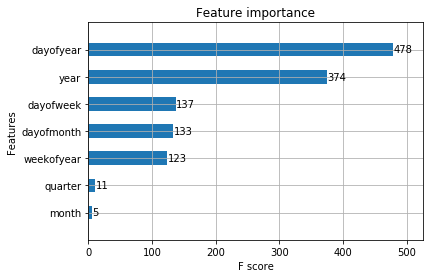

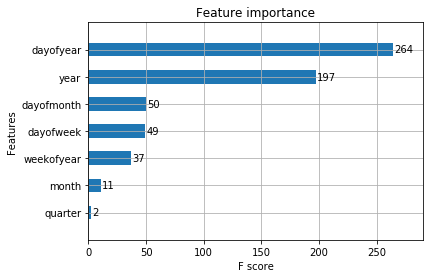

In [56]:
_ = plot_importance(reg, height=0.5)
_ = plot_importance(regf, height=0.5)

In [57]:
test['prediction'] = reg.predict(X_test)
test['predictionf'] = reg.predict(X_testf)

dfall = pd.concat([test, train], sort=False)

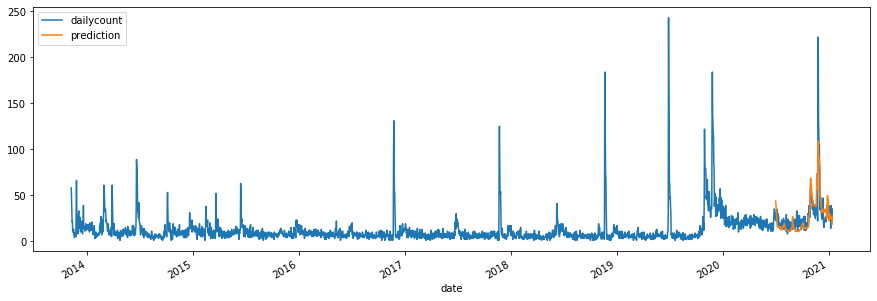

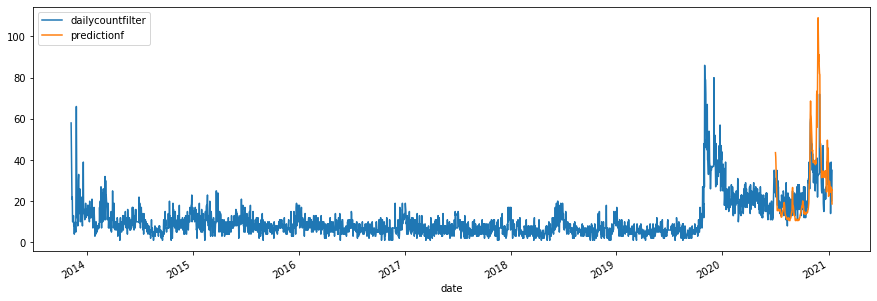

In [58]:
_ = dfall[['dailycount','prediction']].plot(figsize=(15, 5))
_ = dfall[['dailycountfilter','predictionf']].plot(figsize=(15, 5))

In [59]:
print(r2_score(y_true=test['dailycount'],
               y_pred=test['prediction']))

print(mean_squared_error(y_true=test['dailycount'],
                         y_pred=test['prediction']))

print(mean_absolute_error(y_true=test['dailycount'],
                         y_pred=test['prediction']))

print(mean_absolute_percentage_error(y_true=test['dailycount'],
                         y_pred=test['prediction']))

print('-------------------')

print(r2_score(y_true=test['dailycountfilter'],
               y_pred=test['predictionf']))

print(mean_squared_error(y_true=test['dailycountfilter'],
                         y_pred=test['predictionf']))

print(mean_absolute_error(y_true=test['dailycountfilter'],
                         y_pred=test['predictionf']))

print(mean_absolute_percentage_error(y_true=test['dailycountfilter'],
                         y_pred=test['predictionf']))

0.6235531409606847
203.47720989970986
8.818258334179314
30.725074742851348
-------------------
-1.0723830278131445
222.39927946873314
9.268972445507439
35.46063322499003


## pmdarima

In [91]:
adftest = ADFTest(alpha=0.05)

print(adftest.should_diff(reviewcount['dailycount']))
print(adftest.should_diff(reviewcount['dailycountfilter']))

(0.01, False)
(0.01, False)


In [122]:
autoarima = auto_arima(train['dailycount'], start_p=0, d=1, start_q=0,
                       max_p=5, max_d=5, max_q=5, start_P=0,
                       D=1, start_Q=0, max_P=5, max_D=5,
                       max_Q=5, m=12, seasonal=True,
                       error_action='warn', trace=True,
                       supress_warnings=True, stepwise=True,
                       random_state=55, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=19303.139, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=18559.890, Time=0.59 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.94 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=19303.390, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=18257.201, Time=1.58 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=18112.961, Time=2.82 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=18014.984, Time=6.33 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=17963.460, Time=9.58 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=92.96 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=74.04 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=17964.686, Time=9.90 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=17909.643, Time=14.57 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=17958.434, Time=8.36 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=179.89 sec
 ARIMA(2,1,0)(4,1,1)[12]

In [119]:
autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2419
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -8689.040
Date:                Sun, 07 Feb 2021   AIC                          17390.081
Time:                        14:05:39   BIC                          17424.827
Sample:                             0   HQIC                         17402.716
                               - 2419                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0723      0.043      1.698      0.090      -0.011       0.156
ar.L1          1.6608      0.028     58.328      0.000       1.605       1.717
ar.L2         -0.6668      0.026    -25.812      0.000      -0.717      -0.616
ma.L1         -0.8102      0.029    -28.207      0.000      -0.867      -0.754
ma.L2         -0.1290      0.014     -9.122      0.000      -0.157      -0.101
sigma2        77.1322      0.340    227.087      0.000      76.467      77.798
===================================================================================
Ljung-Box (Q):                       51.29   Jarque-Bera (JB):           3913267.32
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               3.39   Skew:                            10.11
Prob(H) (two-sided):                  0.00   Kurtosis:                       199.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
autoarimapredict = pd.DataFrame(autoarima.predict(n_periods=196), index=test.index)
autoarimapredict.columns = ['predicted']
autoarimapredict

,predicted
date,
2020-07-02,21.794718
2020-07-03,20.448318
2020-07-04,19.500594
2020-07-05,18.824367
2020-07-06,18.333213
...,...
2021-01-09,12.250177
2021-01-10,12.247185
2021-01-11,12.244248


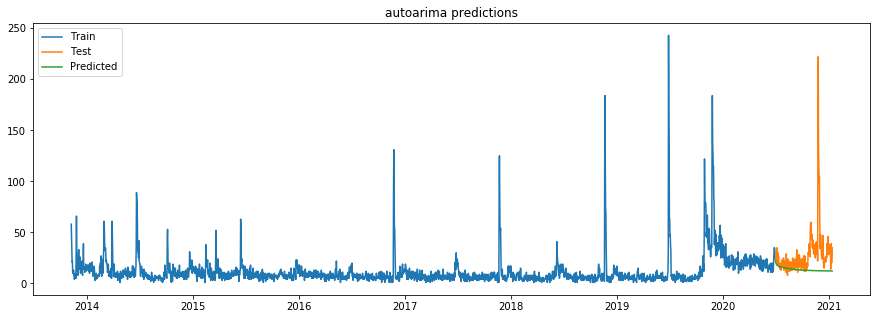

In [121]:
plt.figure(figsize=(15,5))
plt.plot(train.index, train['dailycount'], label='Train')
plt.plot(test.index, test['dailycount'], label='Test')
plt.plot(autoarimapredict.index, autoarimapredict['predicted'], label='Predicted')
plt.legend(loc='best')
plt.title("autoarima predictions")
plt.show()